In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
np.random.seed(42)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-dataset' dataset.
Path to dataset files: /kaggle/input/mnist-dataset


In [4]:
mnist_train = pd.read_csv("/content/sample_data/mnist_train_small.csv")

In [5]:
mnist_train.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
image = mnist_train.iloc[0, 1:].values.reshape(28, 28)
label = mnist_train.iloc[0, 0]

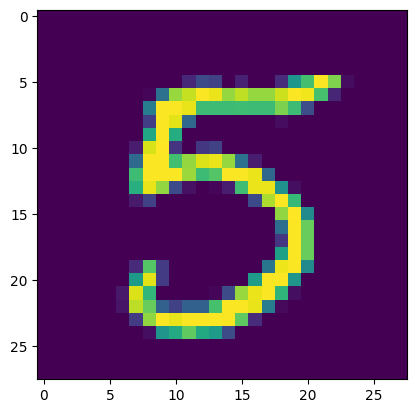

Цифра : 5


In [7]:
im = plt.imshow(image)
plt.show()
print("Цифра :", label)

In [8]:
mnist_test = pd.read_csv("/content/sample_data/mnist_test.csv")
mnist_test.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
mnist_train["6"].value_counts()

,count
6,
1,2243
7,2126
6,2038
9,2023
3,2021
2,1989
0,1962
4,1924
8,1912


In [10]:
X_train = mnist_train.values[:, 1:]
y_train = mnist_train.values[:, 0]

In [11]:
X_test = mnist_test.values[:, 1:]
y_test = mnist_test.values[:, 0]

In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [13]:
class NeuralNetwork:
    def __init__(self, input_n, hidden_n, output_n):

        self.W1 = np.random.randn(input_n, hidden_n) * 1e-1
        self.W2 = np.random.randn(hidden_n, output_n) * 1e-1

        self.b1 = np.zeros((1, hidden_n))
        self.b2 = np.zeros((1, output_n))

        self.alpha = 0.1

    @staticmethod
    def relu(x):
        return np.maximum(x, 0)

    @staticmethod
    def softmax(x):
        z = np.exp(x - np.max(x, axis=1, keepdims=True))
        return z / np.sum(z, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        correct_probs = y_pred[np.arange(len(y_true)), y_true]
        loss = -np.mean(np.log(correct_probs))
        return loss

    @staticmethod
    def encode_labels(y):
        mask = np.zeros((y.size, y.max() + 1))
        mask[np.arange(y.size), y] = 1
        return mask

    def forward(self, x):
        self.Z1 = np.matmul(x, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.matmul(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def step(self):
        self.W1 = self.W1 - self.alpha * self.dW1
        self.b1 = self.b1 - self.alpha * self.db1
        self.W2 = self.W2 - self.alpha * self.dW2
        self.b2 = self.b2 - self.alpha * self.db2

    def backward(self, y_pred, X, y):
        m = X.shape[0]

        y_mask = self.encode_labels(y)
        self.dZ2 = y_pred - y_mask

        self.dW2 = (1 / m) * np.matmul(self.A1.T, self.dZ2)
        self.db2 = (1 / m) * np.sum(self.dZ2, axis=0, keepdims=True)

        self.dA1 = np.matmul(self.dZ2, self.W2.T)
        self.dZ1 = self.dA1 * (self.Z1 > 0)

        self.dW1 = (1 / m) * np.matmul(X.T, self.dZ1)
        self.db1 = (1 / m) * np.sum(self.dZ1, axis=0, keepdims=True)

In [14]:
model = NeuralNetwork(784, 300, 10)

In [15]:
class DataLoader:
    def __init__(self, X, y, batch_size: int = 64):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.current_idx = 0

    def __iter__(self):
        self.current_idx = 0
        return self

    def __next__(self):
        if self.current_idx >= self.X.shape[0]:
            raise StopIteration

        X_batch = self.X[self.current_idx:self.current_idx + self.batch_size]
        y_batch = self.y[self.current_idx:self.current_idx + self.batch_size]

        self.current_idx += self.batch_size

        return X_batch, y_batch

In [16]:
train_iterator = DataLoader(X_train, y_train, batch_size=64)
test_iterator = DataLoader(X_test, y_test, batch_size=64)

In [17]:
NUM_EPOCH = 20
for i in range(NUM_EPOCH):
    print(f"Epoch: {i+1}")
    epoch_accuracy = []
    epoch_loss = []
    for X_batch, y_batch in train_iterator:
        y_pred = model.forward(X_batch)
        loss = model.cross_entropy_loss(y_pred, y_batch)

        model.backward(y_pred, X_batch, y_batch)
        model.step()

        labels_pred = np.argmax(y_pred, axis=1)
        accuracy = np.mean(labels_pred == y_batch)
        epoch_accuracy.append(accuracy)

        epoch_loss.append(loss)
    print(f"Epoch Accuracy: {sum(epoch_accuracy) / len(epoch_accuracy)}")
    print(f"Epoch Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 1
Epoch Accuracy: 0.8536148613830774
Epoch Loss: 0.49905311245195855
Epoch: 2
Epoch Accuracy: 0.9216688781820056
Epoch Loss: 0.2745139039561732
Epoch: 3
Epoch Accuracy: 0.937144117798619
Epoch Loss: 0.22013789525170044
Epoch: 4
Epoch Accuracy: 0.9482795269504276
Epoch Loss: 0.1841600021179627
Epoch: 5
Epoch Accuracy: 0.9563166675255075
Epoch Loss: 0.1577729923997926
Epoch: 6
Epoch Accuracy: 0.9627563640111305
Epoch Loss: 0.13705004861089184
Epoch: 7
Epoch Accuracy: 0.9685970189632072
Epoch Loss: 0.12015384828780472
Epoch: 8
Epoch Accuracy: 0.9727903096980315
Epoch Loss: 0.10614930607780342
Epoch: 9
Epoch Accuracy: 0.9762847186437184
Epoch Loss: 0.09437454466738912
Epoch: 10
Epoch Accuracy: 0.9794329073482428
Epoch Loss: 0.08436235118179157
Epoch: 11
Epoch Accuracy: 0.9821785143769968
Epoch Loss: 0.07572465140960777
Epoch: 12
Epoch Accuracy: 0.9844249201277955
Epoch Loss: 0.06820252126154622
Epoch: 13
Epoch Accuracy: 0.9866713258785943
Epoch Loss: 0.06169187364486969
Epoch: 14
Ep

In [19]:
test_pred = model.forward(X_test)
test_pred_labels = np.argmax(test_pred, axis=1)
accuracy = np.mean(test_pred_labels == y_test)
print("Test accuracy: ", accuracy)

Test accuracy:  0.9647964796479648
